# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this : https://github.com/numenta/NAB <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. This is the very beginning of the process. Still need to do a lot of works!



# What's new in version 3
1. Remove HTM model <br>
2. Use real server data
3. Add LSTM as "Neural network with memory cell" baseline
4. Add DeepAR
5. Add Transformer

In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM




In [2]:
# plot path:
plot_path = "plots/"

# AWS data
aws = pd.read_csv("Data/realKnownCause/realKnownCause/"+'ambient_temperature_system_failure.csv')


In [3]:
# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

os.listdir(root_path)



['cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [4]:

# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


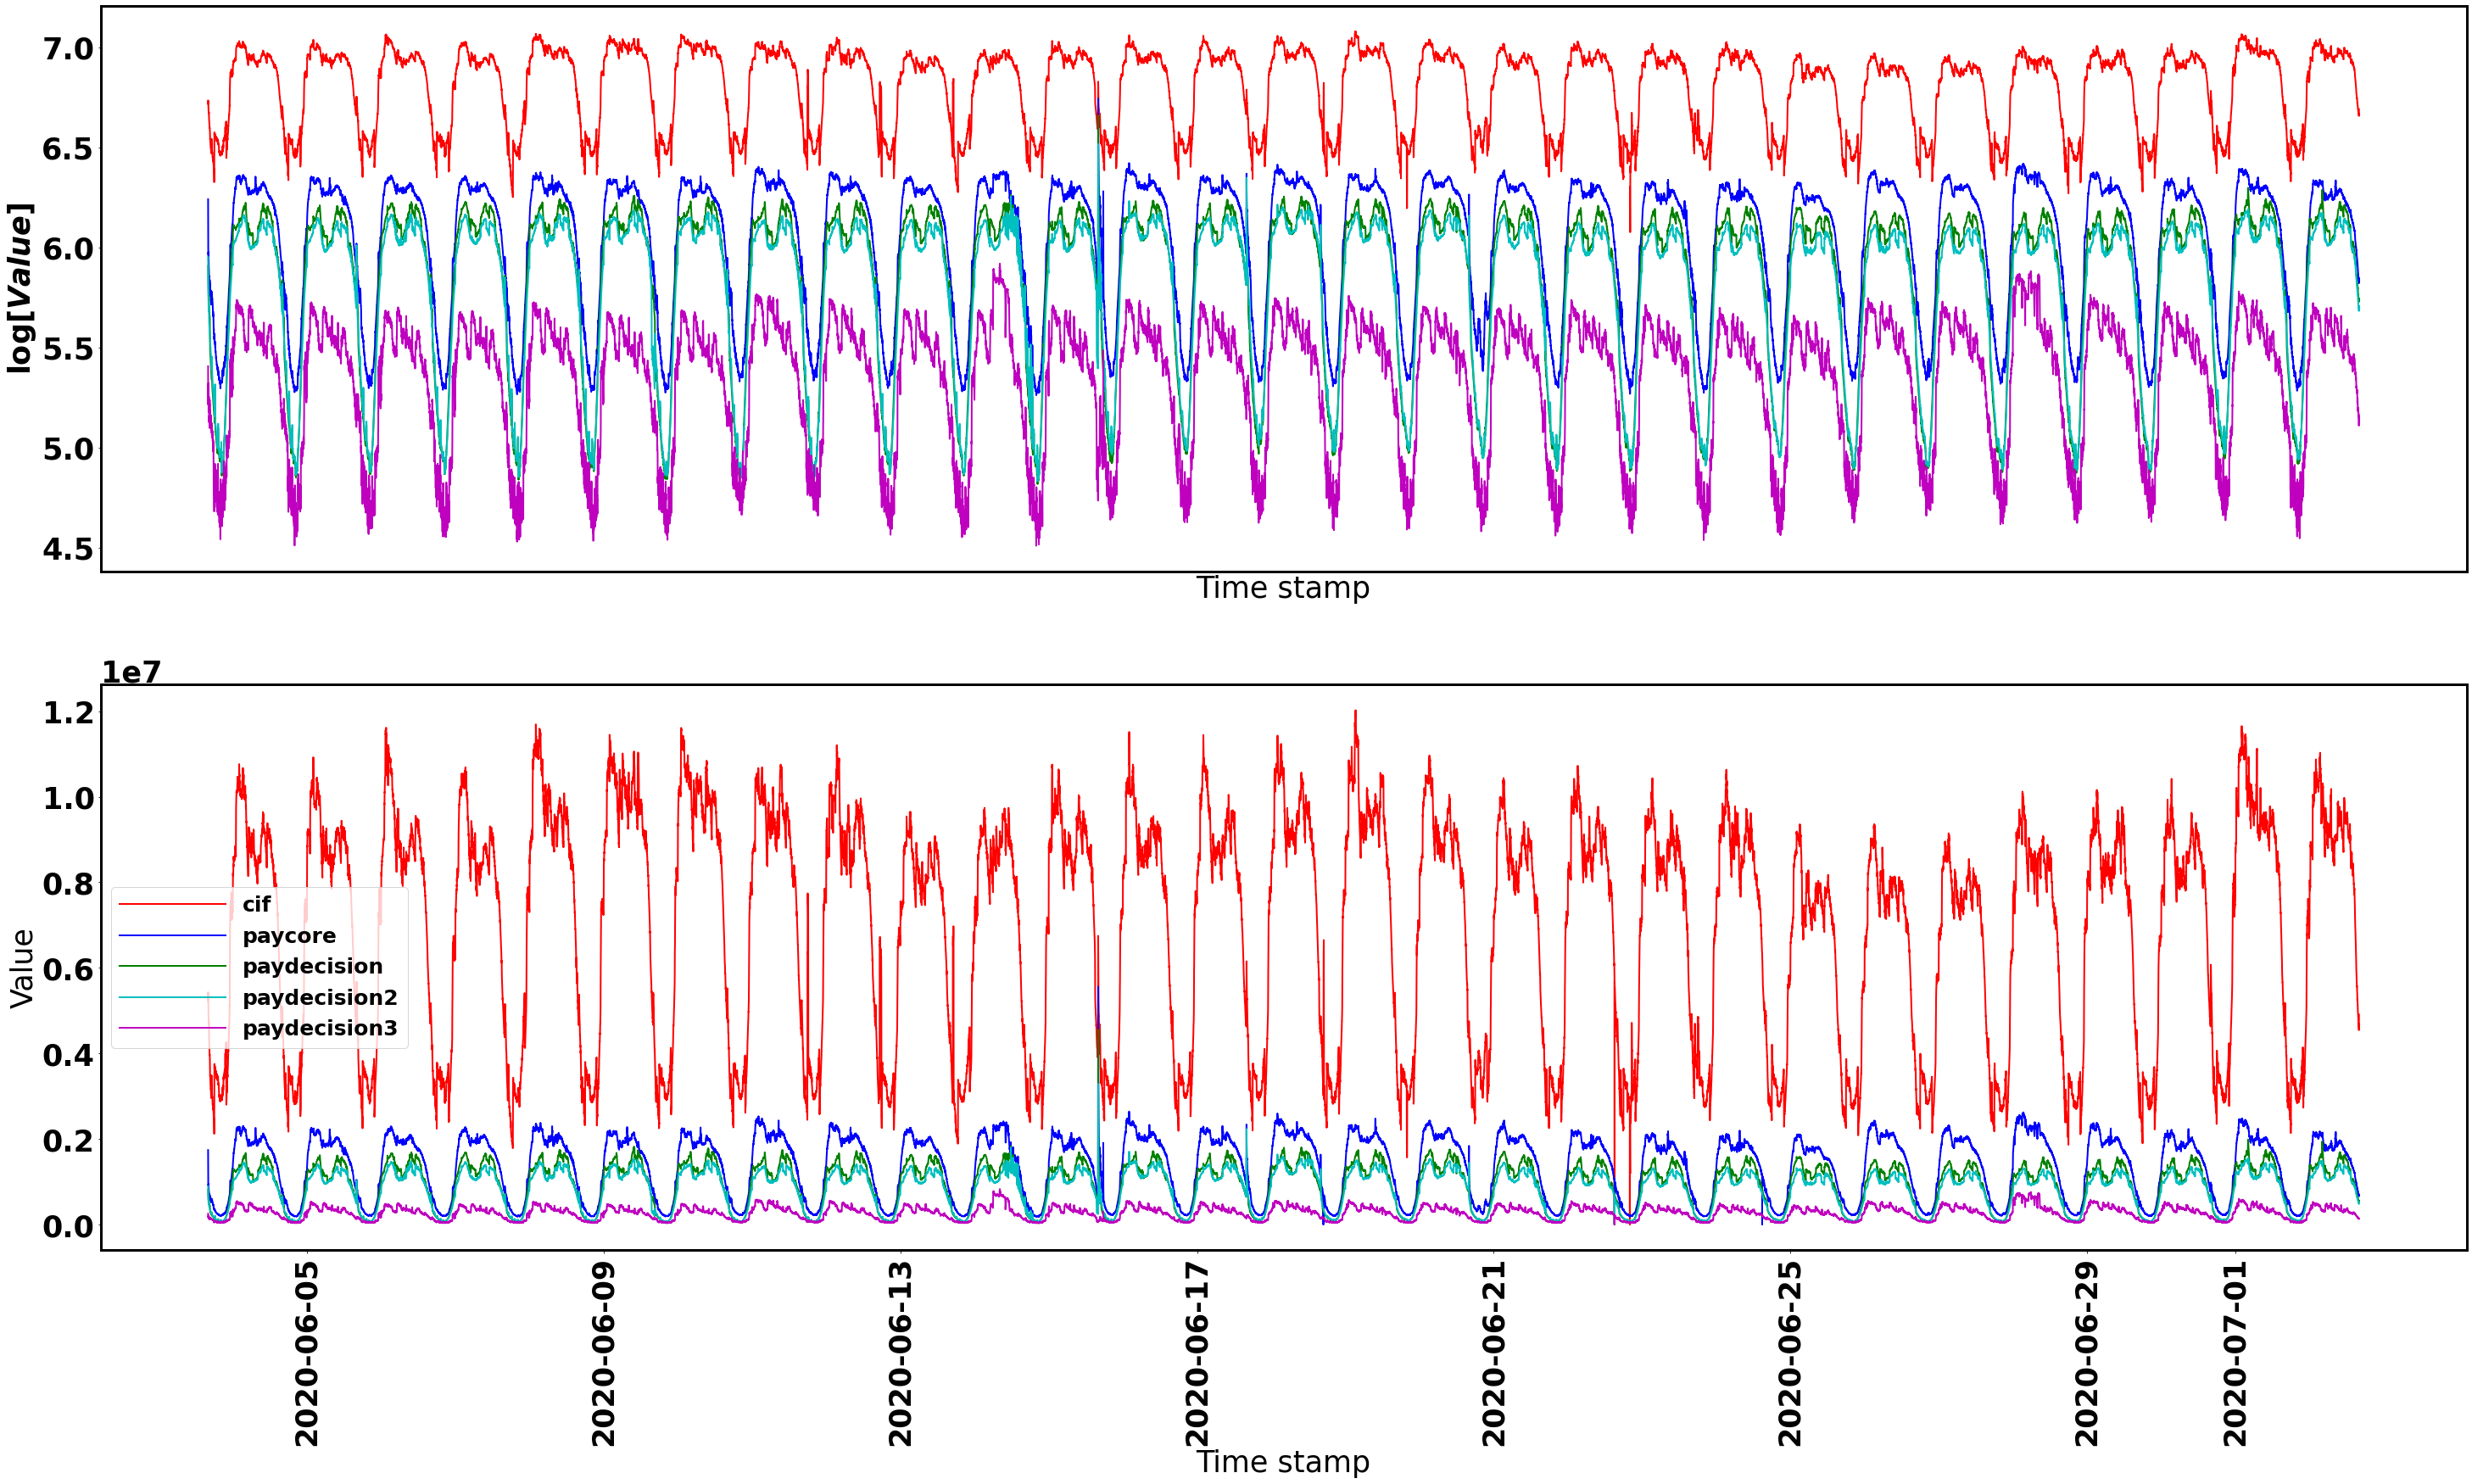

In [5]:
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 35}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)


for i in range(len(names_array)):
    plt.plot(df['time_stamp'],np.log10(df[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    



plt.xlabel("Time stamp")
plt.ylabel(r"$\log[Value]$")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df['time_stamp'],df[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel("Time stamp")
plt.ylabel(r"Value")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,27)
plt.legend(fontsize=25,handlelength=5)

save_path = plot_path + "Data_server_original" + ".png"

fig.savefig(save_path, dpi=300)



# group by hours
There is a trend in hours, which proves it's a time series problem.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


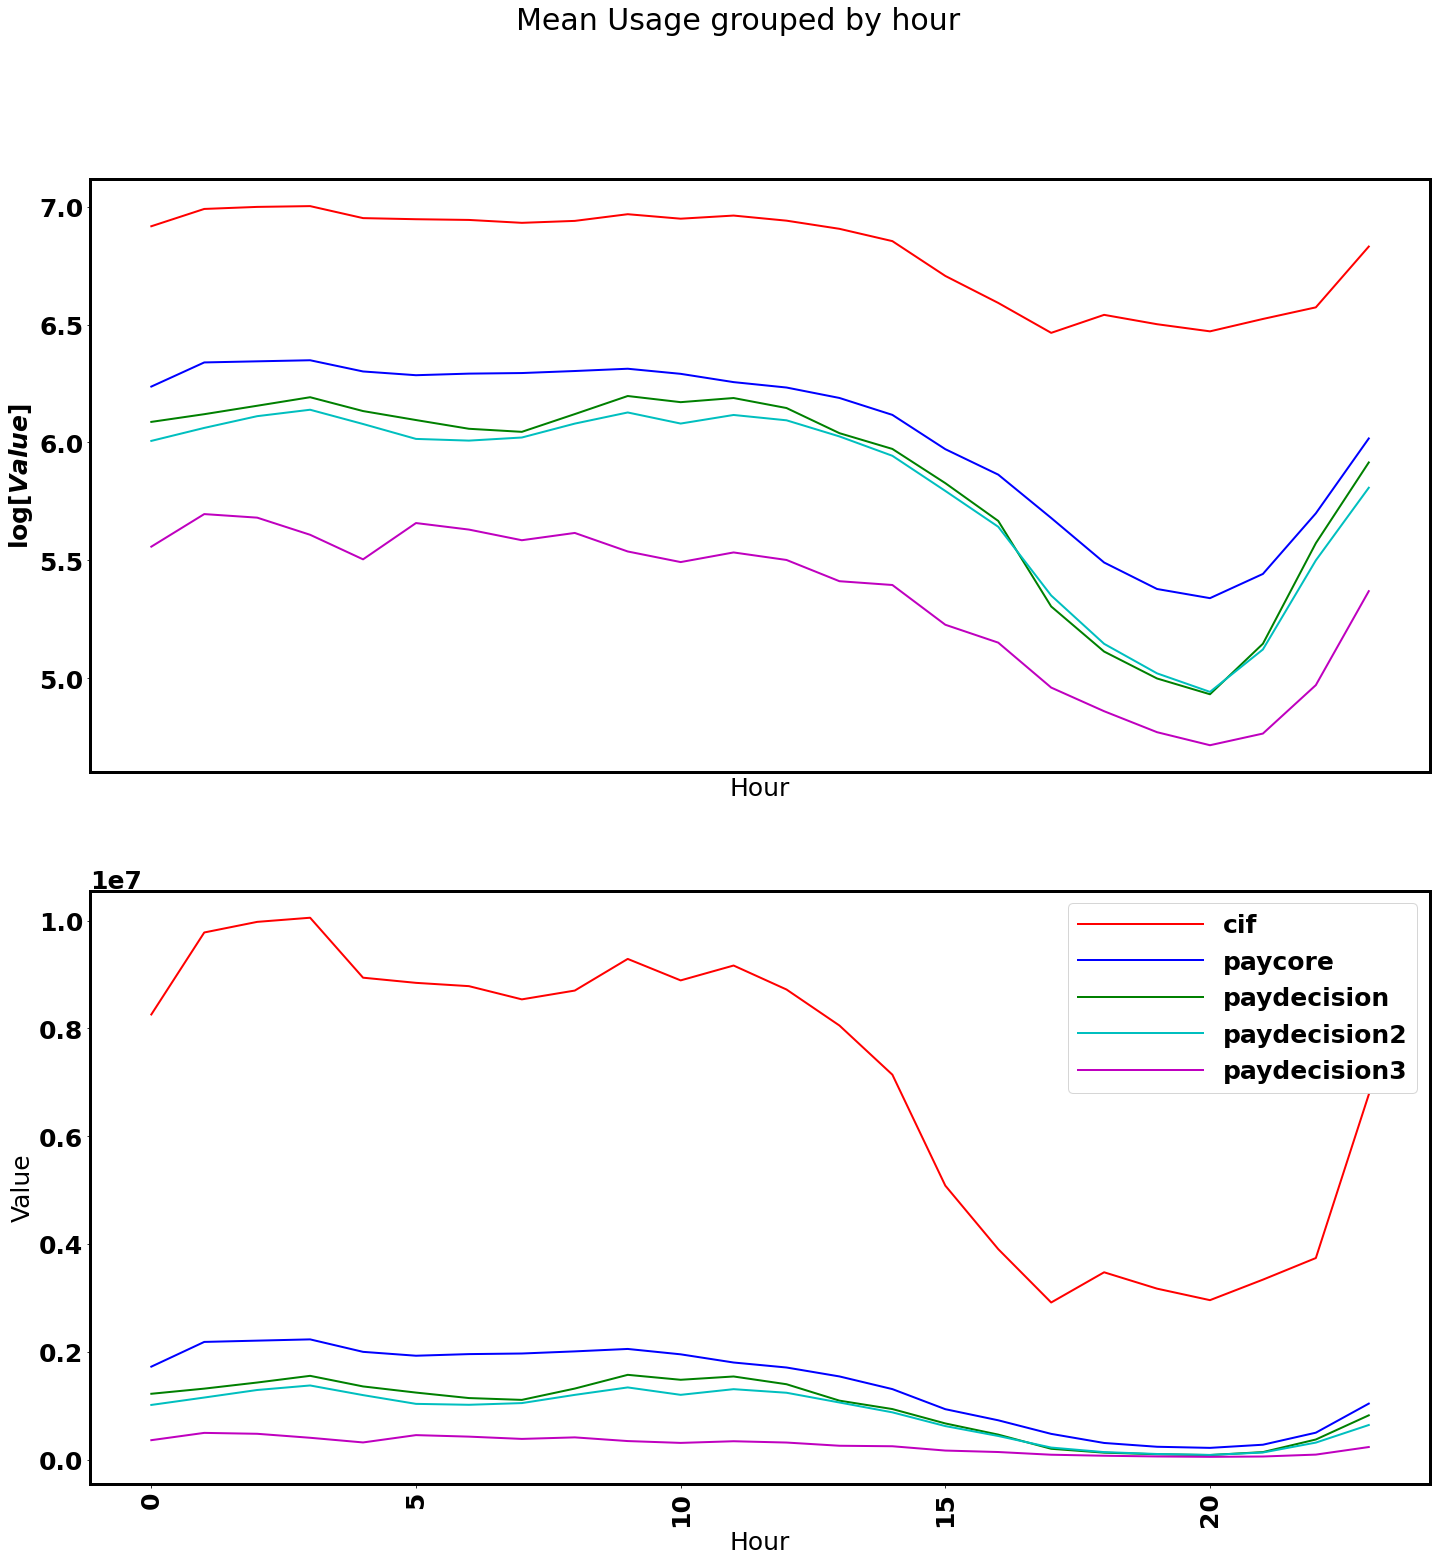

In [6]:
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


df['hours'] = df['time_stamp'].dt.hour

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)



for i in range(len(names_array)):
    plt.plot(df.groupby('hours').mean().index,np.log10(df.groupby('hours').mean()[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Hour")
plt.ylabel(r"$\log[Value]$")
plt.suptitle("Mean Usage grouped by hour")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df.groupby('hours').mean().index,df.groupby('hours').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel("Hour")
plt.ylabel(r"Value")
plt.suptitle("Mean Usage grouped by hour")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,24)
plt.legend(fontsize=25,handlelength=5)
save_path = plot_path + "Data_server_original_group_by_hour" + ".png"

fig.savefig(save_path, dpi=300)




Doing cif
Doing paycore
Doing paydecision
Doing paydecision2
Doing paydecision3


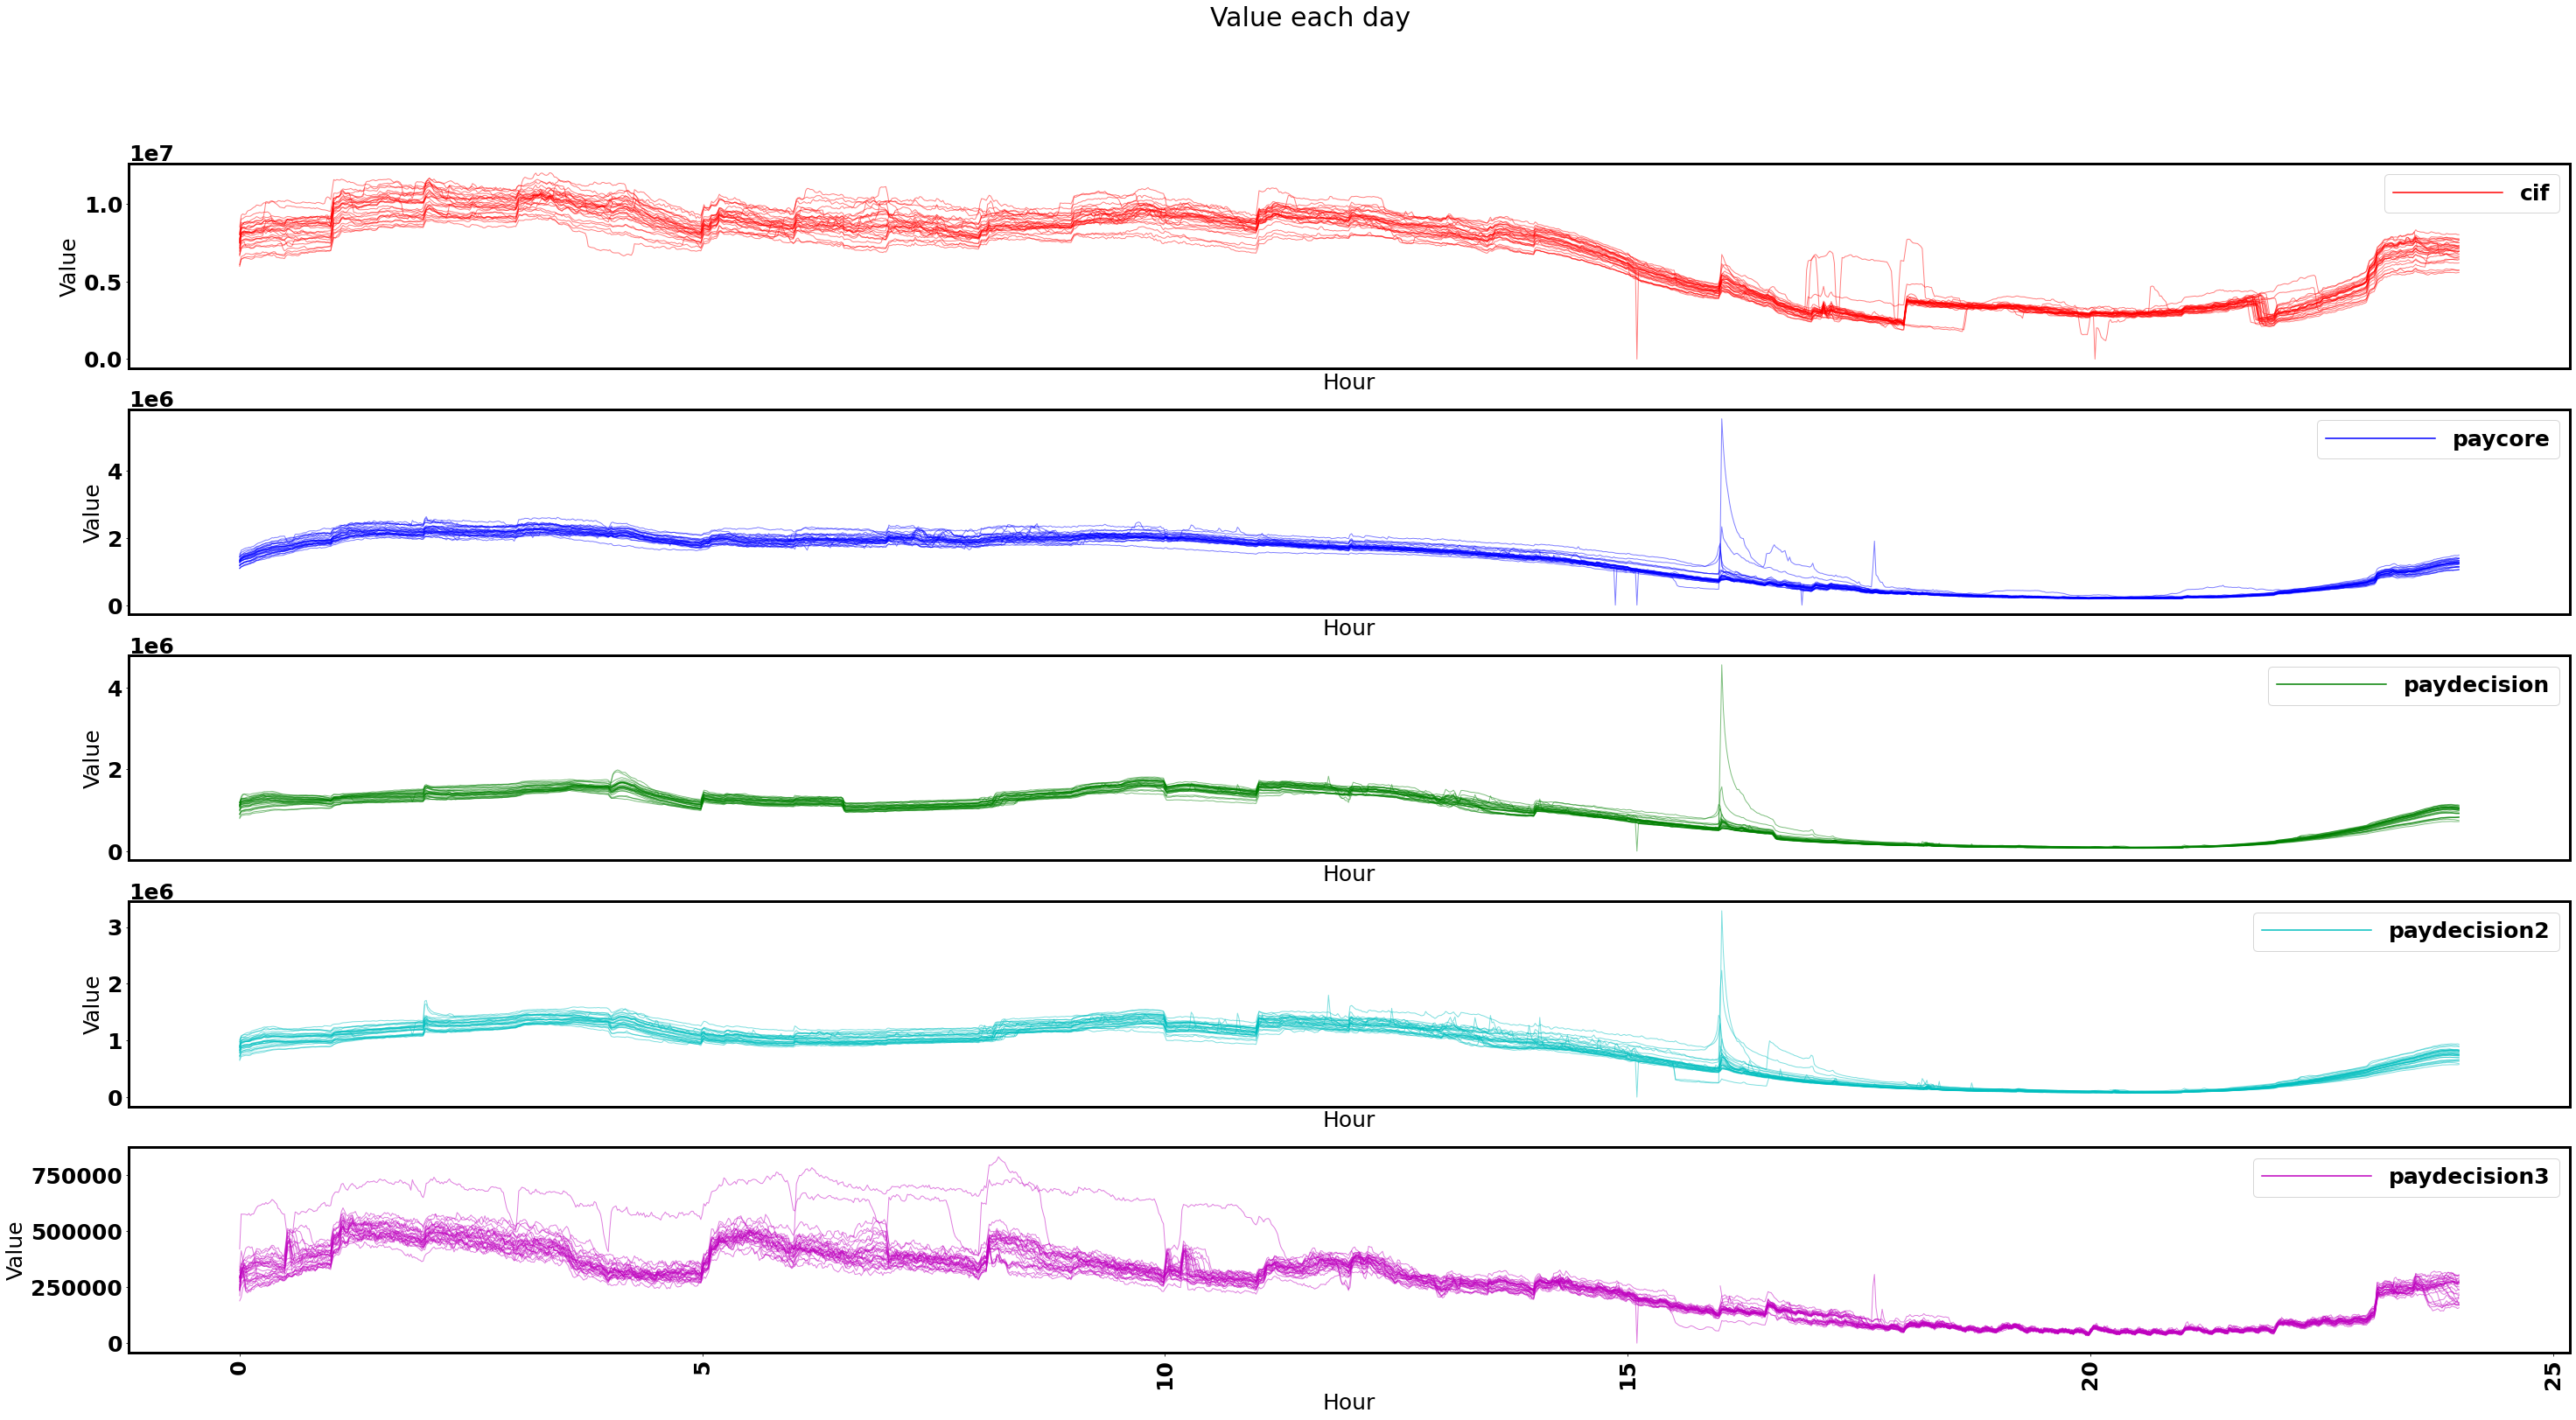

In [7]:
# Another plot: data for each day:
df['days'] = df['time_stamp'].dt.day

    
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')




df["hours_float"] =df['time_stamp'].dt.hour + df['time_stamp'].dt.minute/60

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)






for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    print("Doing %s"%names_array[i])
    plt.plot([],[],color_array[i],label=names_array[i])
    for j in range(1,31):
        mask_d = df['days']==j
        plt.plot(df["hours_float"][mask_d],df[names_array[i]][mask_d],color_array[i],linewidth=1,alpha=0.5)
    plt.xlabel("Hour")
    plt.ylabel(r"Value")
    plt.suptitle("Mean Usage grouped by hour")
    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    plt.legend(fontsize=25,handlelength=5)
        




plt.suptitle("Value each day")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,25)

save_path = plot_path + "Data_server_each_day" + ".png"

fig.savefig(save_path, dpi=200)




    

Doing cif
Doing paycore
Doing paydecision
Doing paydecision2
Doing paydecision3


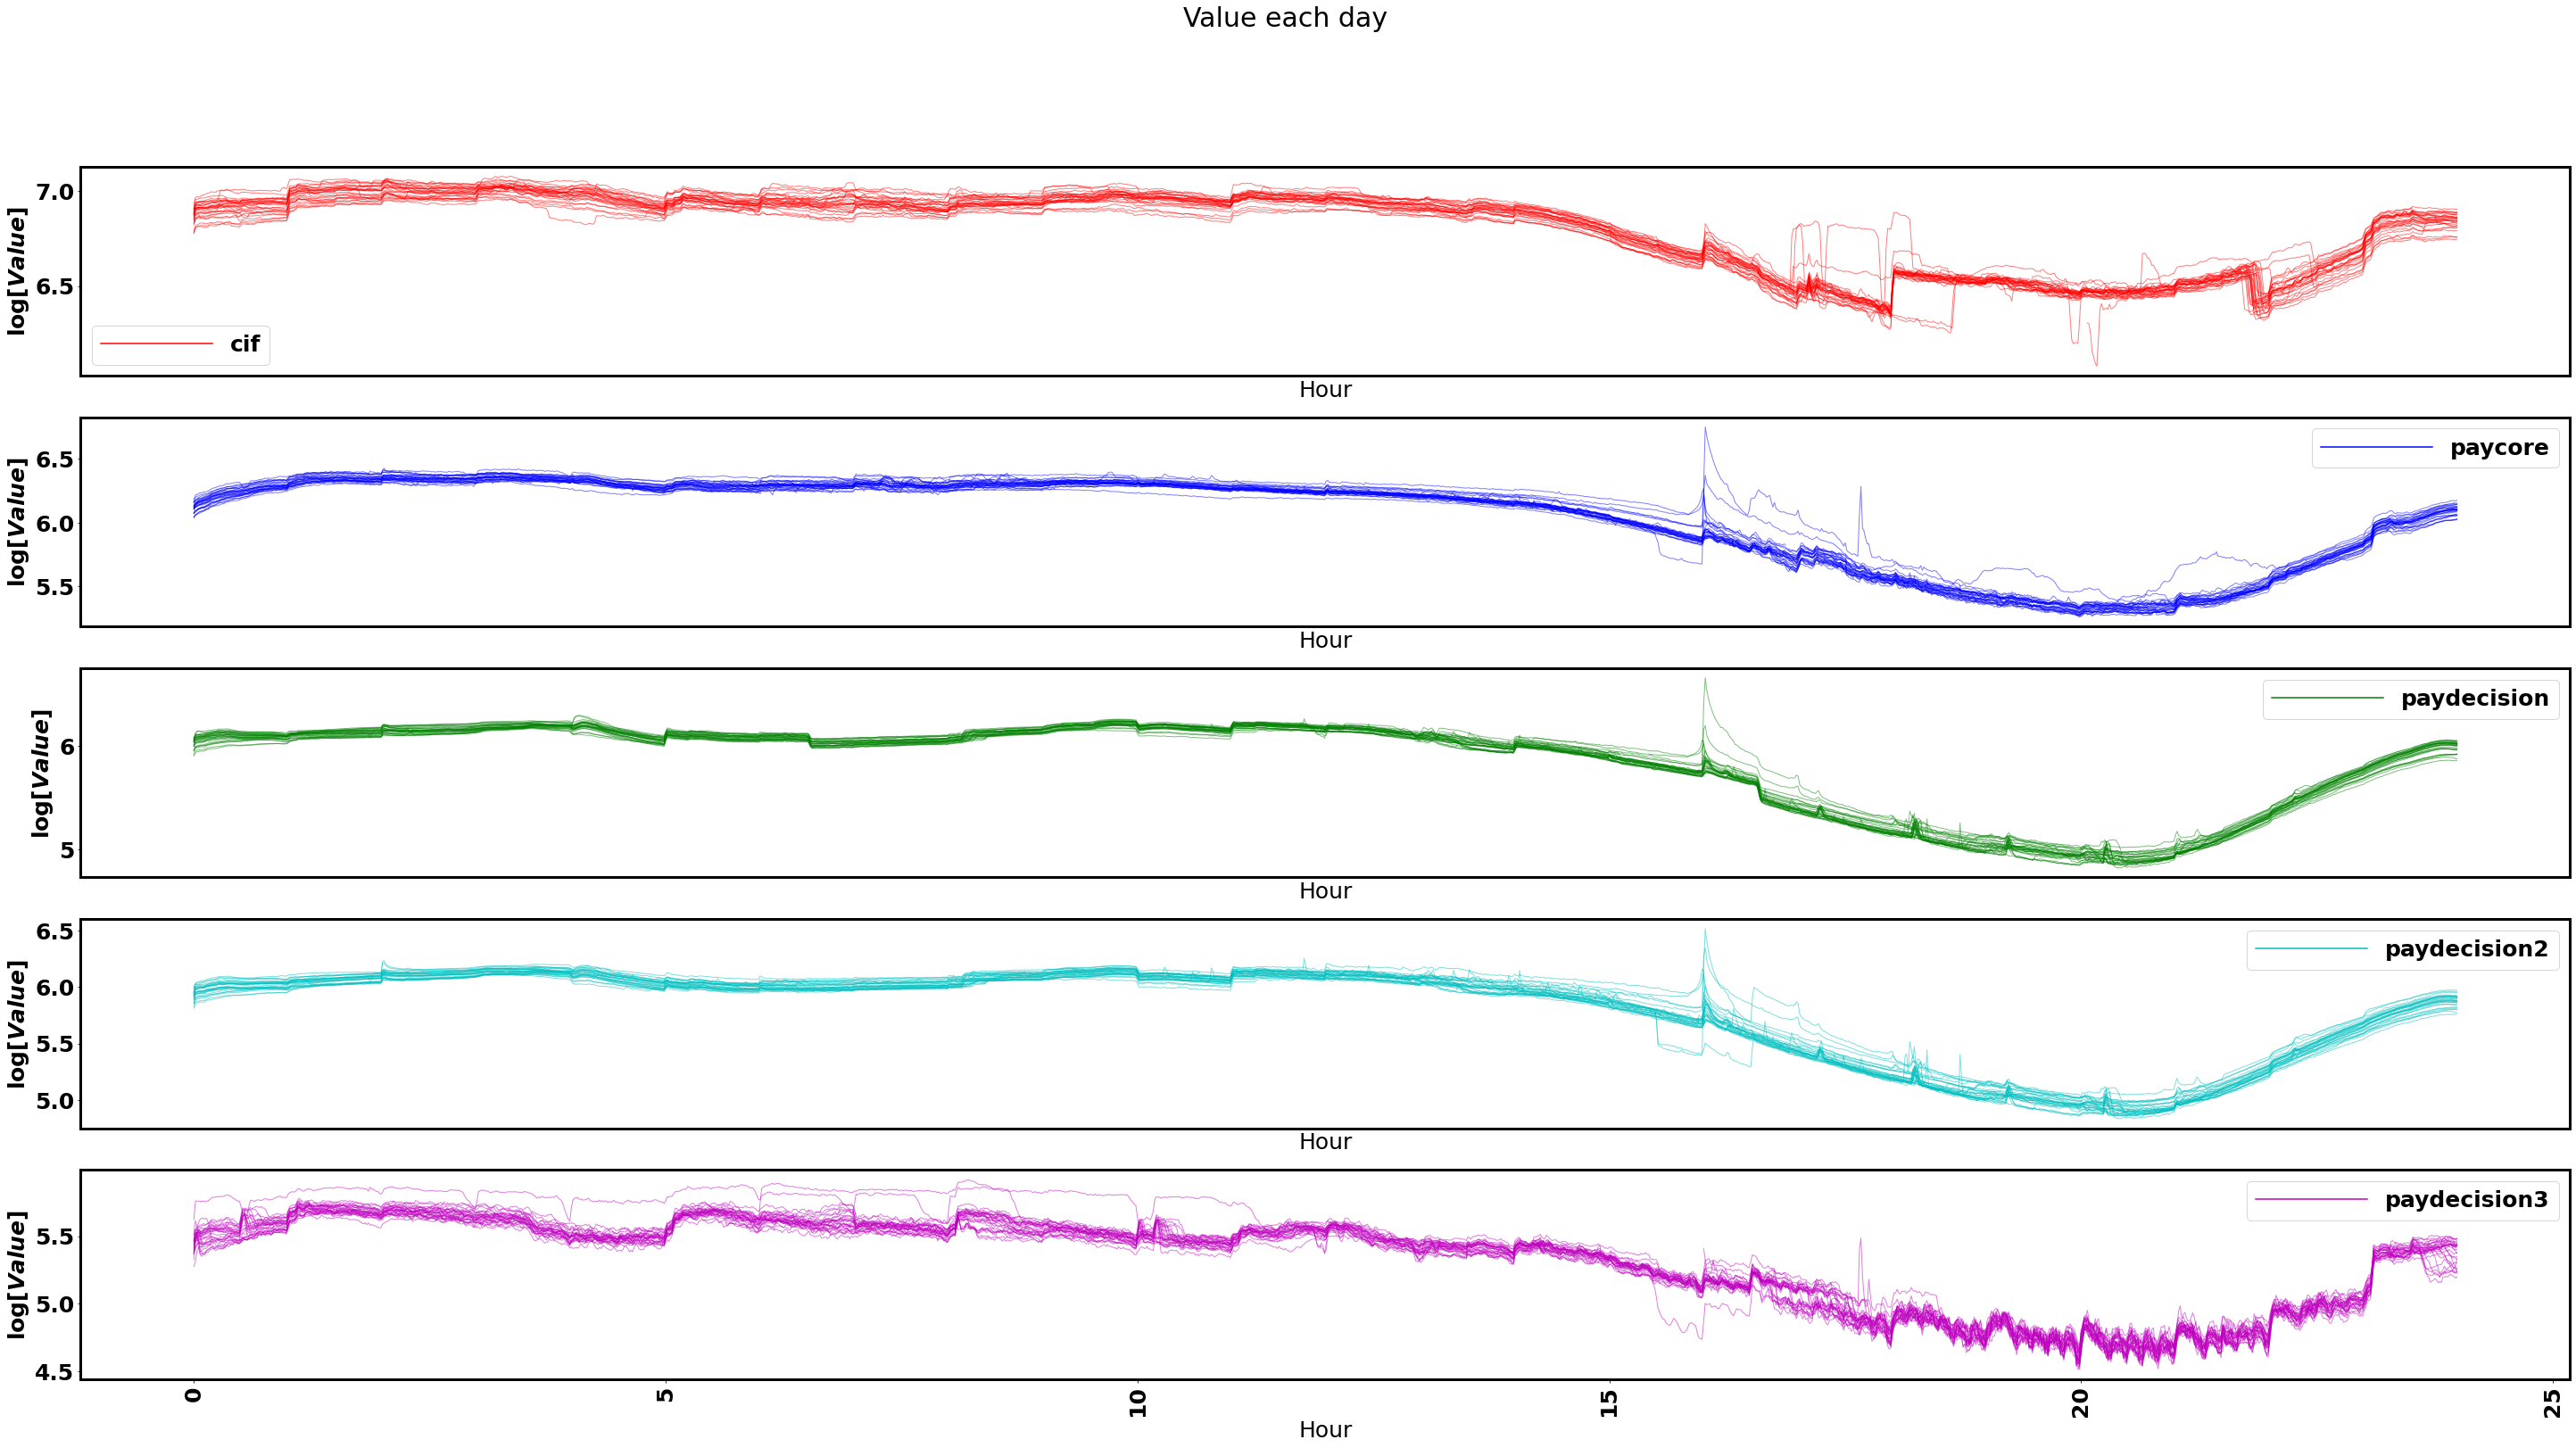

In [8]:
# Another plot: data for each day using log
df['days'] = df['time_stamp'].dt.day


import warnings
warnings.filterwarnings('ignore')




df["hours_float"] =df['time_stamp'].dt.hour + df['time_stamp'].dt.minute/60

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)






for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    print("Doing %s"%names_array[i])
    plt.plot([],[],color_array[i],label=names_array[i])
    for j in range(1,31):
        mask_d = df['days']==j
        plt.plot(df["hours_float"][mask_d],np.log10(df[names_array[i]][mask_d]),color_array[i],linewidth=1,alpha=0.5)
    plt.xlabel("Hour")
    plt.ylabel(r"$\log[Value]$")
    plt.suptitle("Mean Usage grouped by hour")
    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    plt.legend(fontsize=25,handlelength=5)
        




plt.suptitle("Value each day")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,25)

save_path = plot_path + "Data_server_each_day_log" + ".png"

fig.savefig(save_path, dpi=200)




    

Doing cif
Doing paycore
Doing paydecision
Doing paydecision2
Doing paydecision3


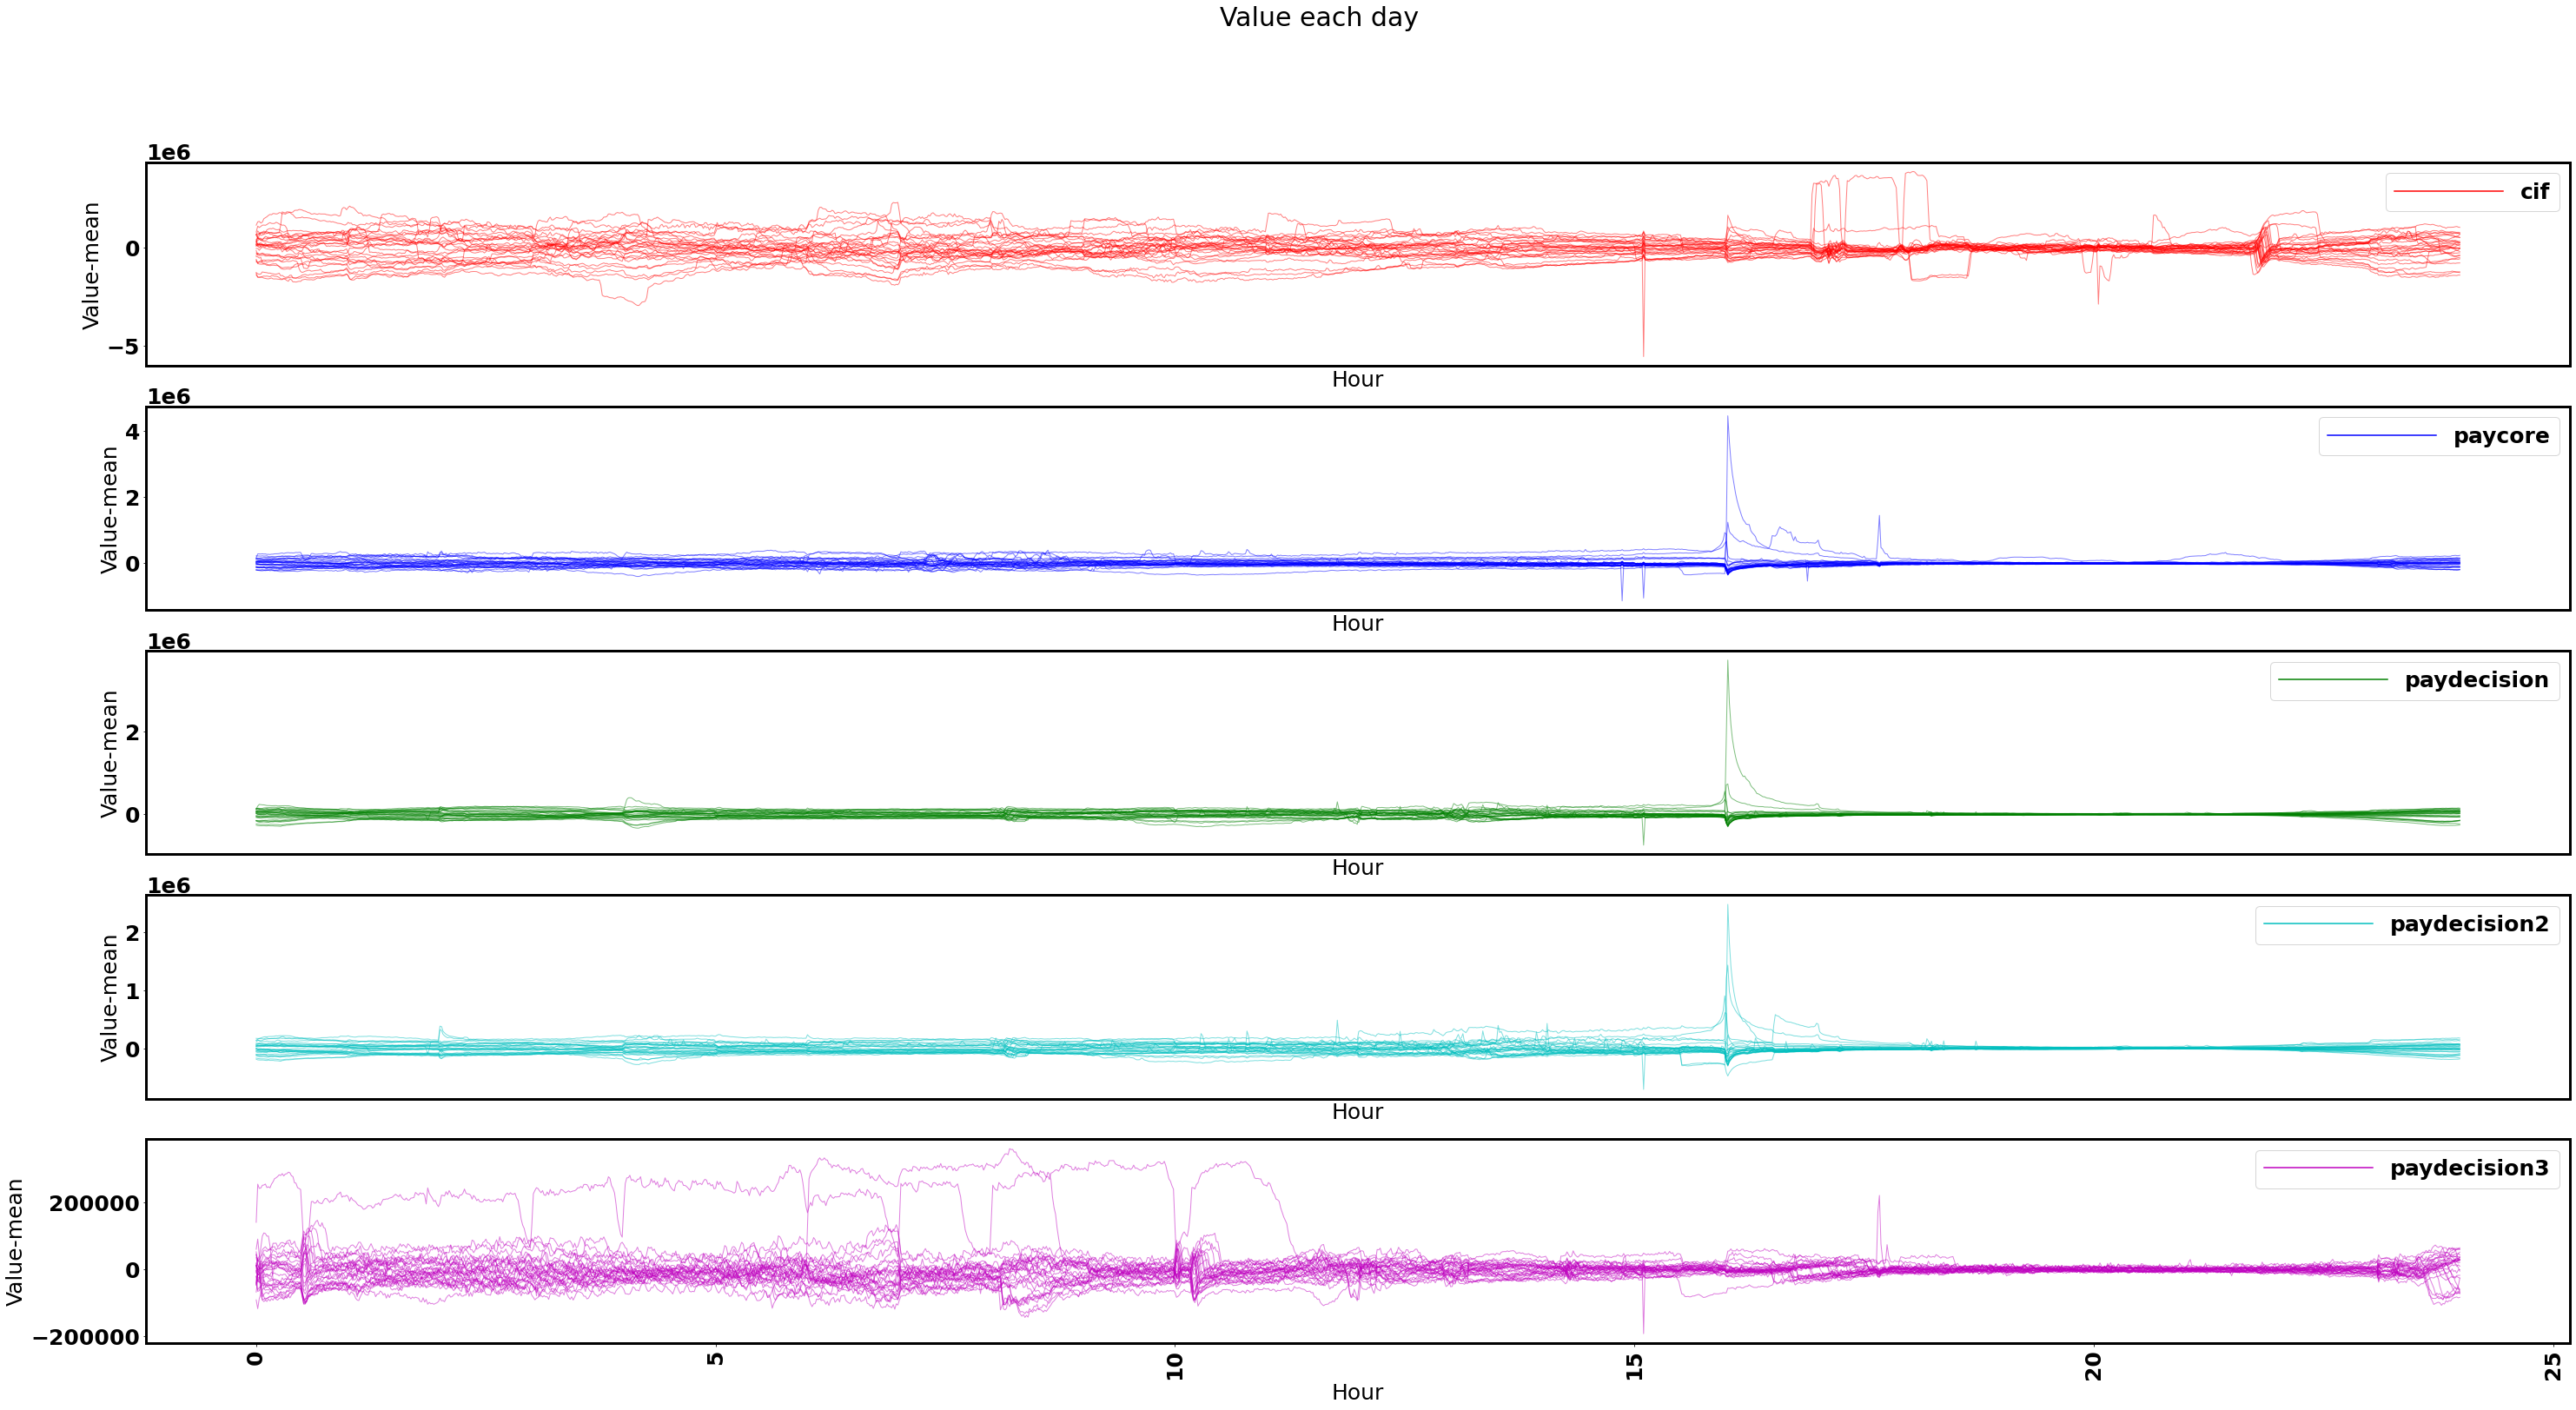

In [24]:
# Another plot: data for each day minus mean each day
df['days'] = df['time_stamp'].dt.day

    
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')




df["hours_float"] =df['time_stamp'].dt.hour + df['time_stamp'].dt.minute/60

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)






for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    print("Doing %s"%names_array[i])
    plt.plot([],[],color_array[i],label=names_array[i])
    offset = np.array(df.groupby("hours_float").mean()[names_array[i]])
    for j in range(1,31):
        mask_d = df['days']==j
        try:
            plt.plot(df["hours_float"][mask_d],df[names_array[i]][mask_d]-offset,color_array[i],linewidth=1,alpha=0.5)
        except:
            pass
    plt.xlabel("Hour")
    plt.ylabel(r"Value-mean")
    plt.suptitle("Mean Usage grouped by hour minus mean")
    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    plt.legend(fontsize=25,handlelength=5)
        




plt.suptitle("Value each day")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,25)

save_path = plot_path + "Data_server_each_day_minus_mean" + ".png"

fig.savefig(save_path, dpi=200)




    

# Group by day of week:
There seems to be no trend here:

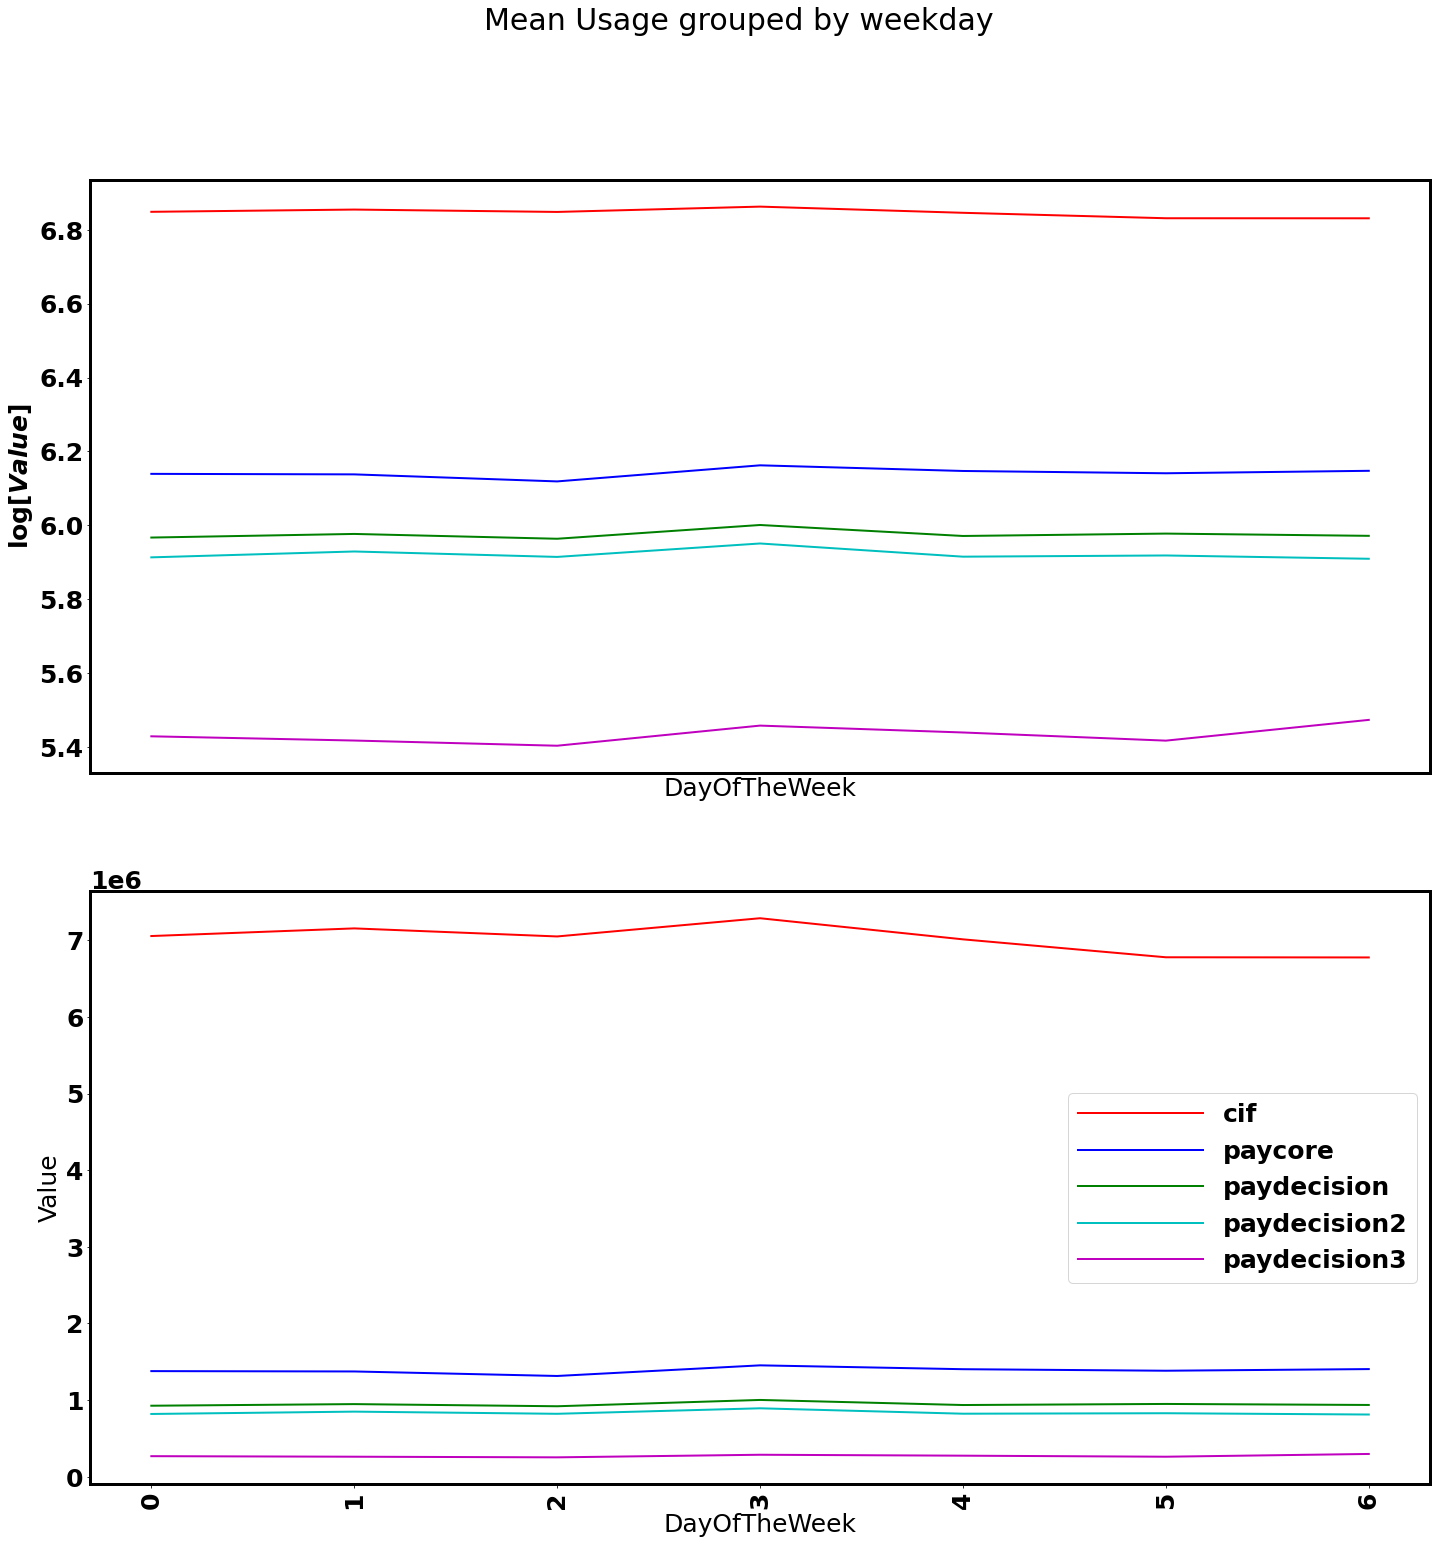

In [20]:
# Group by day of week:


## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')

df['DayOfTheWeek'] = df['time_stamp'].dt.dayofweek

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)



for i in range(len(names_array)):
    plt.plot(df.groupby('DayOfTheWeek').mean().index,np.log10(df.groupby('DayOfTheWeek').mean()[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel('DayOfTheWeek')
plt.ylabel(r"$\log[Value]$")
plt.suptitle("Mean Usage grouped by weekday")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df.groupby('DayOfTheWeek').mean().index,df.groupby('DayOfTheWeek').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel('DayOfTheWeek')
plt.ylabel(r"Value")
plt.suptitle("Mean Usage grouped by weekday")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,24)
plt.legend(fontsize=25,handlelength=5)
save_path = plot_path + "Data_server_original_group_by_weekday" + ".png"

fig.savefig(save_path, dpi=300)





# Baseline:
Isolation Forest. Performance not good.

cif 0    40513
1     1248
Name: anomaly_iforest_cif, dtype: int64
paycore 0    40509
1     1252
Name: anomaly_iforest_paycore, dtype: int64
paydecision 0    40508
1     1253
Name: anomaly_iforest_paydecision, dtype: int64
paydecision2 0    40512
1     1249
Name: anomaly_iforest_paydecision2, dtype: int64
paydecision3 0    40508
1     1253
Name: anomaly_iforest_paydecision3, dtype: int64


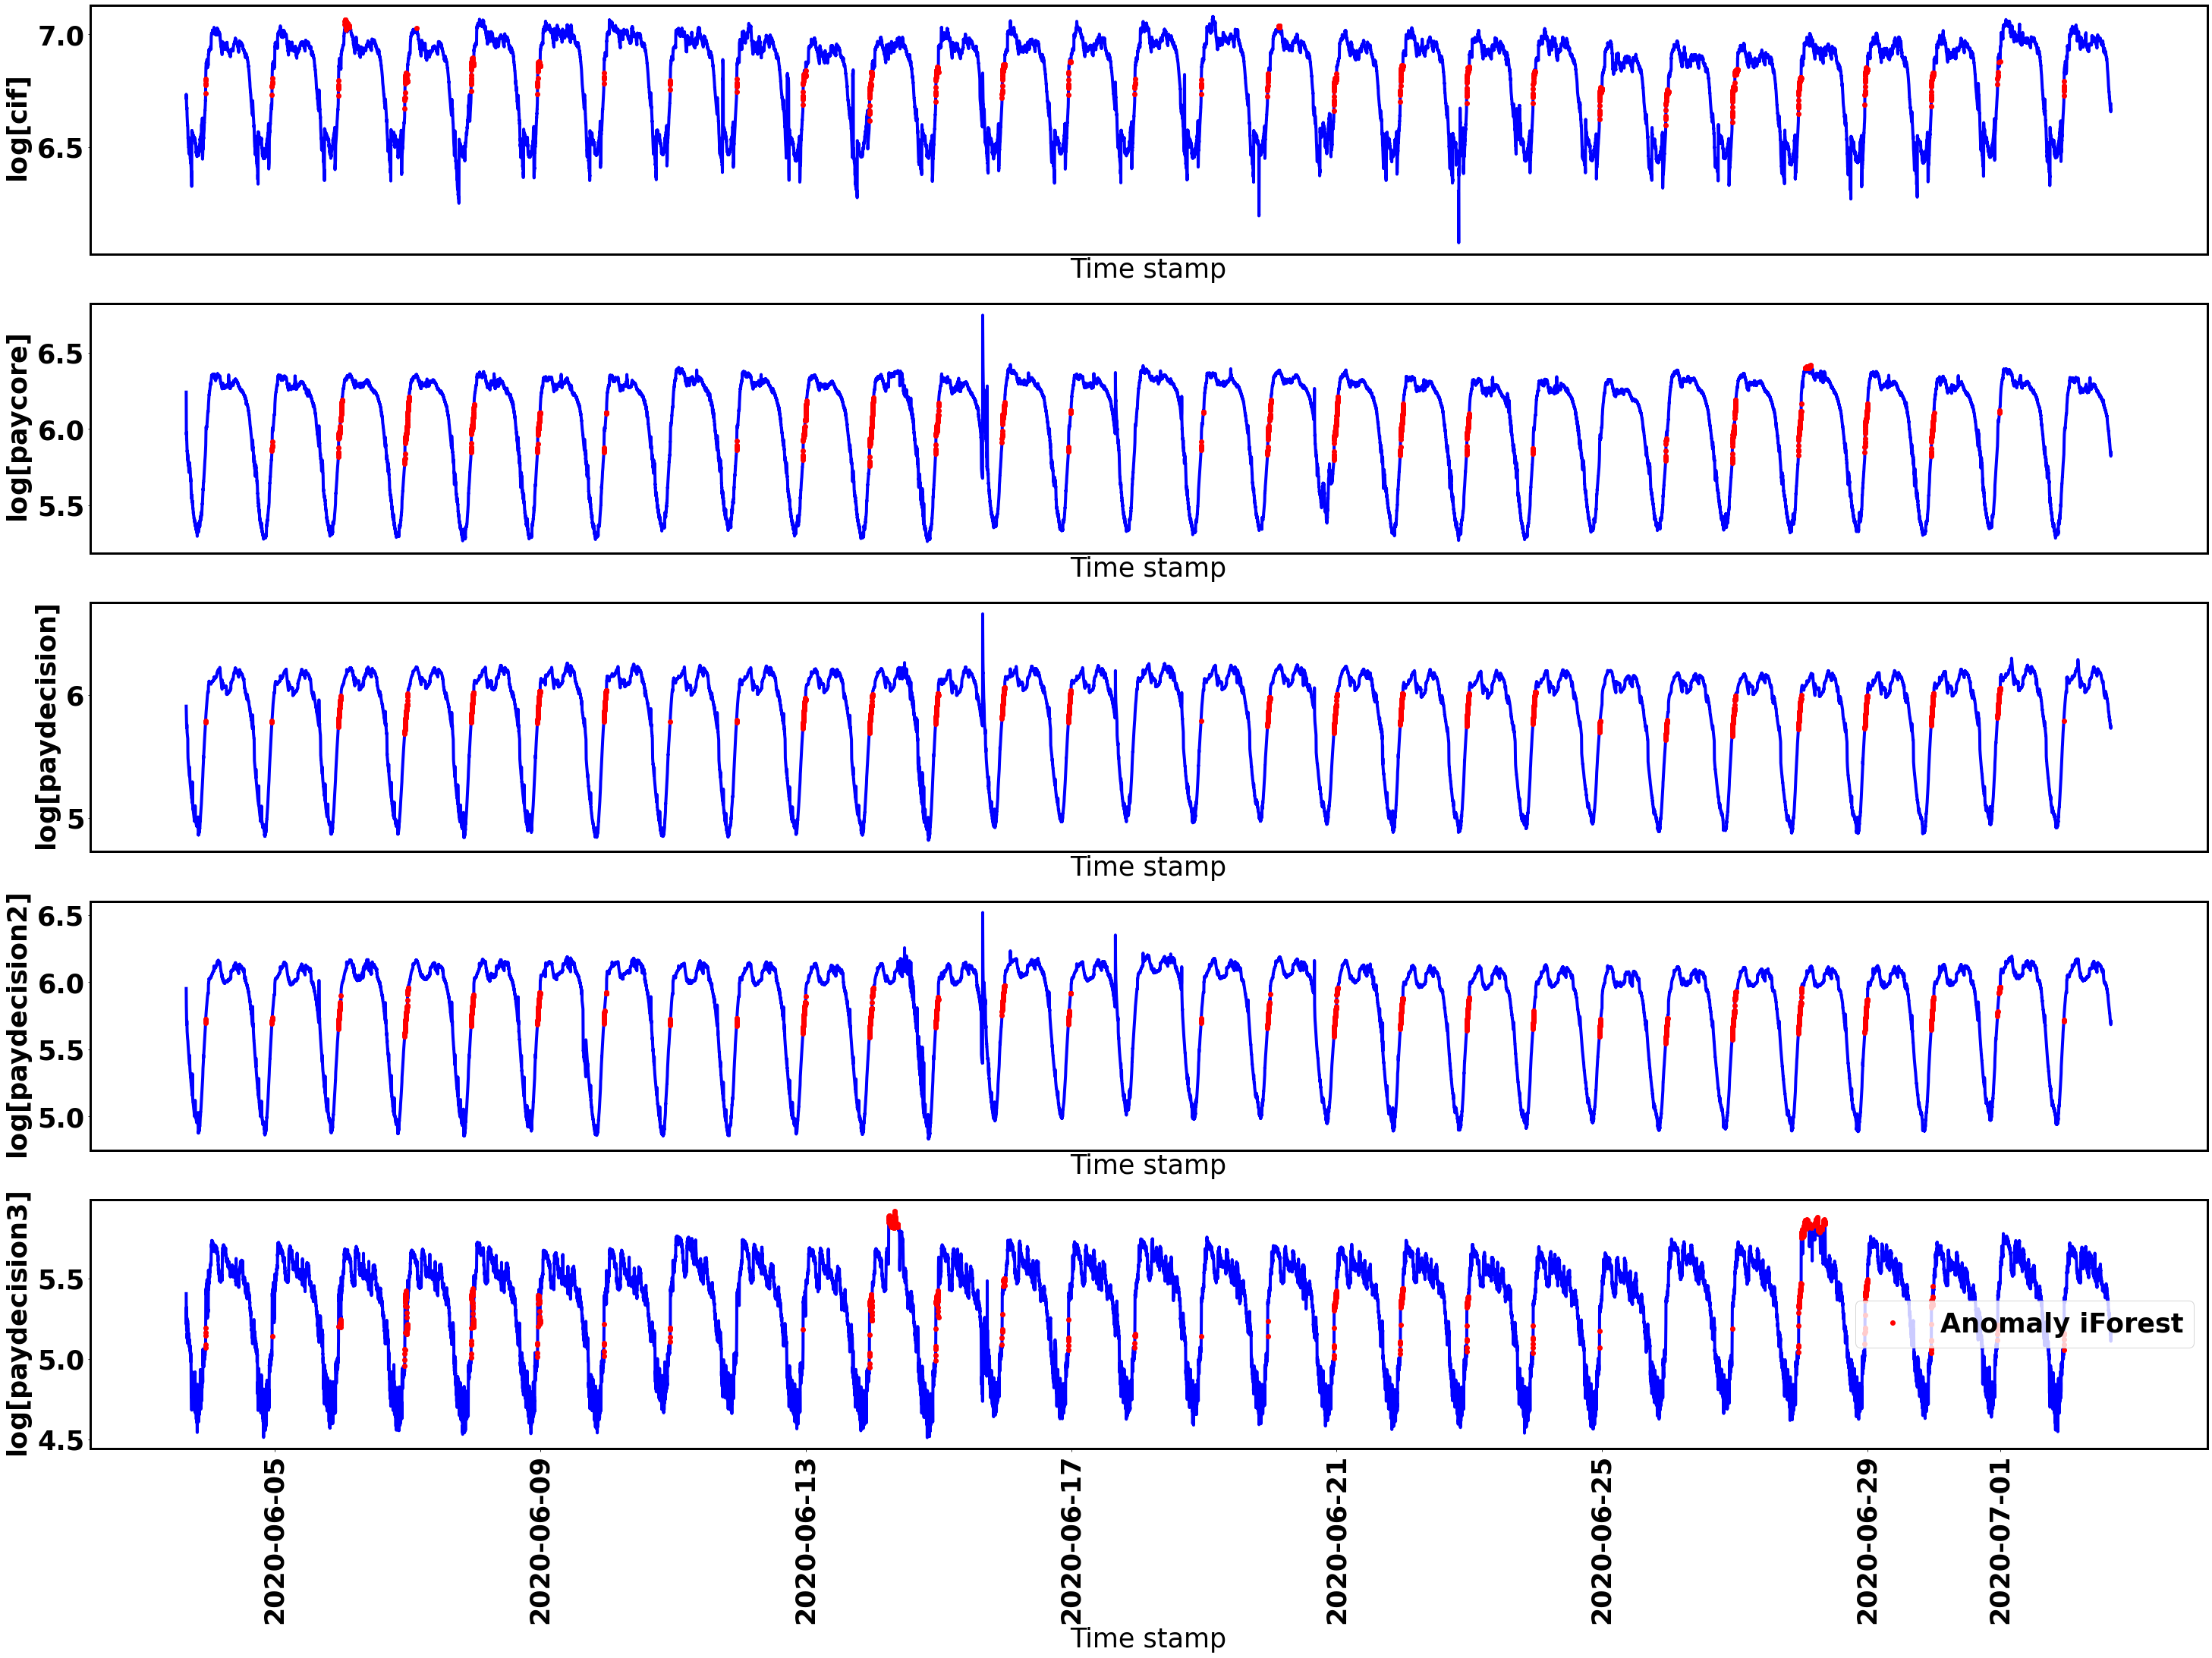

In [21]:
import gc


def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return -np.inf

    
## Some hyper-parameters:
outliers_fraction=0.03

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['time_stamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)



font = {'family': 'normal','weight': 'bold',
        'size': 35}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    
    data = df[[names_array[i], 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
    # try use log?
    if False:
        temp = np.log10(data[names_array[i]])
        mask_inf = np.isinf(temp)
        temp[mask_inf]=-9999
        data[names_array[i]] = temp
    
    min_max_scaler = preprocessing.StandardScaler()

    # min-max scaler
    np_scaled = min_max_scaler.fit_transform(data)

    data = pd.DataFrame(np_scaled)

    # train Iforest 
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(data)
    # add the data to the main  
    df['anomaly_iforest_'+names_array[i]] = pd.Series(model.predict(data))
    df['anomaly_iforest_'+names_array[i]] = df['anomaly_iforest_'+names_array[i]].map( {1: 0, -1: 1} )
    print(names_array[i],df['anomaly_iforest_'+names_array[i]].value_counts())


    mask = df['anomaly_iforest_'+names_array[i]]==1

    plt.plot(df['time_stamp'],np.log10(df[names_array[i]]),"b",linewidth=4)

    plt.plot(df[mask]['time_stamp'],np.log10(df[mask][names_array[i]]),"ro",linewidth=4,label="Anomaly iForest")

    plt.xlabel("Time stamp")
    plt.ylabel(r"$\log [\rm %s]$"%names_array[i])

    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    gc.collect()


fig = matplotlib.pyplot.gcf()




fig.set_size_inches(50,35)
plt.legend()


save_path = plot_path + "Data_server_iForest" + ".png"

fig.savefig(save_path, dpi=200)



In [22]:
# There seems to be a strong correlation between these input parameters

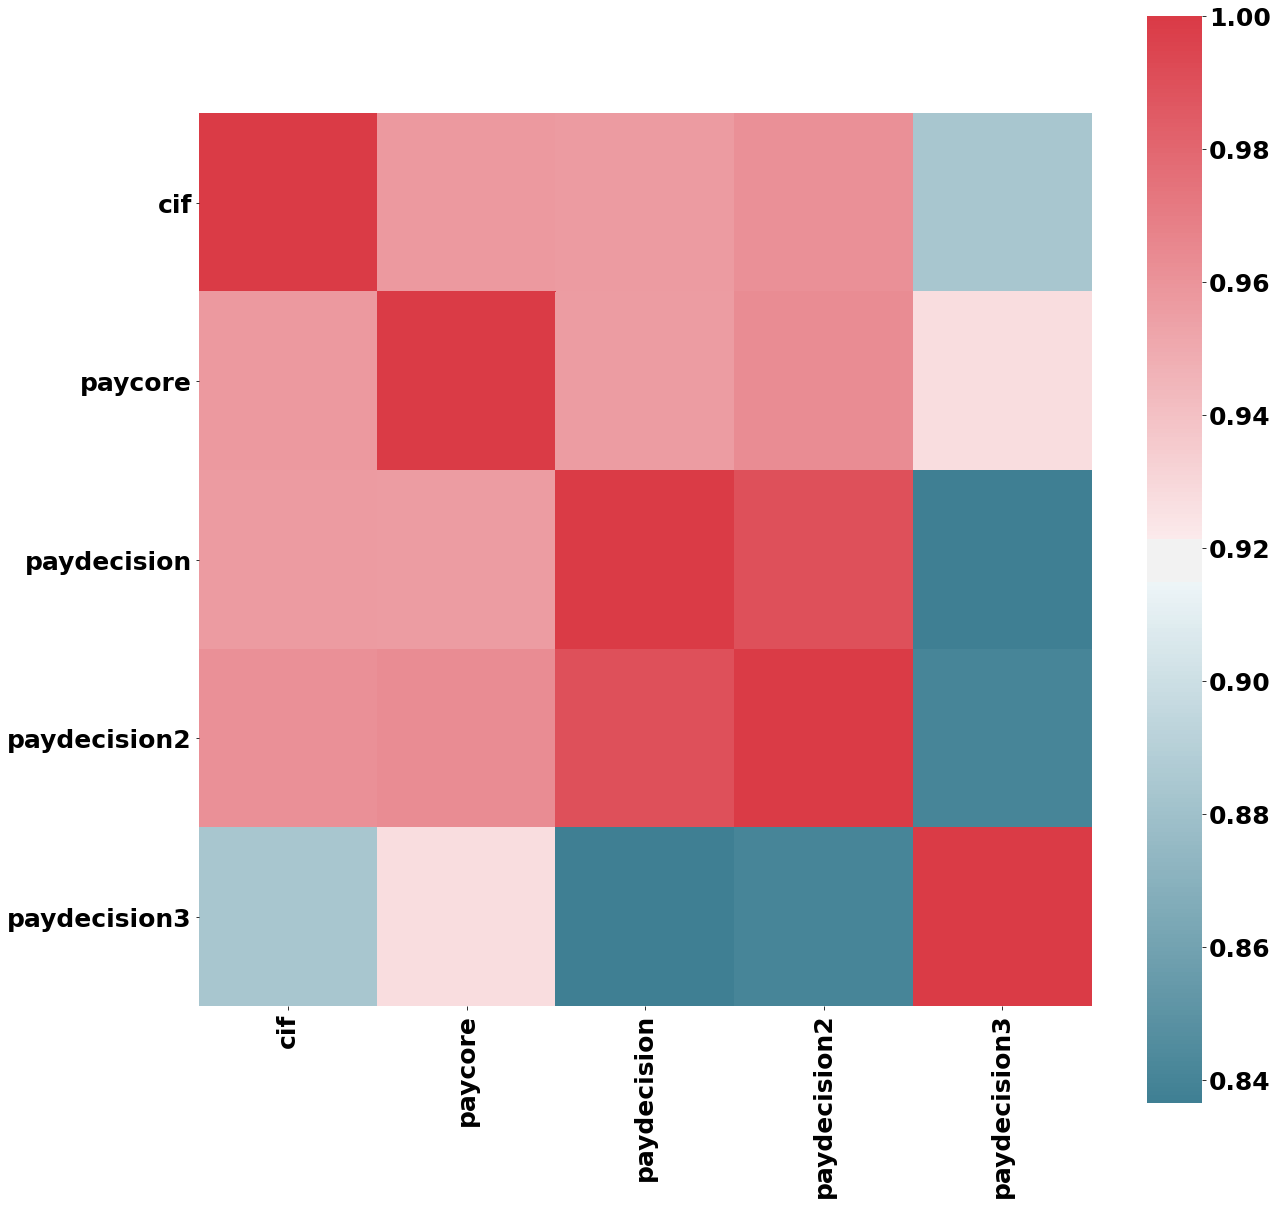

In [36]:

import seaborn as sns


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)




f, ax = plt.subplots()
corr = df[names_array].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(20,20)
save_path = plot_path + "Correlation_v1" + ".png"

fig.savefig(save_path, dpi=150)



# Hidden Markov Model is here!
The idea is to use Hidden Markov Model(HMM) to predict future values vs time, then we assume dots with a huge different between data and predicted are anomalys <br>

# To be continued :) 
I still need to figure out some details before applying this model

In [25]:
## Place holder for HMM

# Variational auto encoder (VAE)
I will do this before applying Transformer <br>
Thanks to google's colab doc here https://www.tensorflow.org/tutorials/generative/cvae <br>
Still, I don't think VAE can handle a dateset as small as 30 (30 days) <br>
Postponed for now

In [26]:
if False:
    import glob
    import matplotlib.pyplot as plt
    import numpy as np
    import PIL
    import tensorflow as tf
    import time

    # Hyper-parameters
    batch_size=30

    class VAE(tf.keras.Model):

        def __init__(self,latent_dim):
            super(VAE, self).__init__()
            self.latent_dim = latent_dim
            # encoder
            self.encoder = tf.keras.Sequential(layers=None, name=None)
            self.encoder.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))

            self.encoder.add(tf.keras.layers.Conv2D(
                        filters=32, kernel_size=3, strides=(2, 2), activation='relu'))
            self.encoder.add(tf.keras.layers.Conv2D(
                        filters=64, kernel_size=3, strides=(2, 2), activation='relu'))

            self.encoder.add(tf.keras.layers.Flatten())
            self.encoder.add(tf.keras.layers.Dense(latent_dim + latent_dim))

            # decoder:
            self.decoder = tf.keras.Sequential(layers=None, name=None)

            self.decoder.add(tf.keras.layers.InputLayer(input_shape=(latent_dim,)))
            self.decoder.add(tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu))
            self.decoder.add(tf.keras.layers.Reshape(target_shape=(7, 7, 32)))
            self.decoder.add(tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'))
            self.decoder.add(tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'))
            self.decoder.add(tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'))




    model = VAE(latent_dim=20)
    model.encoder.summary()
    model.decoder.summary()

    # Define Optimizer:
    optimizer = tf.keras.optimizers.Adam(1e-4)

# Another thought: LSTM
Use previous several days data to predict future data data using LSTM regressor?
Won't work great but will give a shot

In [5]:
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute

In [6]:
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
index_name=0
n_epoch=20
n_cell = 50
checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [7]:


# shape -1*delta_t*1
## Remember to normalize the data before put that into the LSTM

min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]

import sys
print("Size of input X in GB: %.2f"%float(sys.getsizeof(X)/1024**3))

Size of input X in GB: 2.16


In [38]:
# Prepare the data:

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df_scaled[i:i+delta_t][names_array].values
    
# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print("Finished preparing data")   

Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent
Finished preparing data


In [9]:
import tensorflow as tf
# design network: A toy LSTM model with 50 units
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fitting+save model

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)


## load model
#model.load_weights(checkpoint_path)




In [ ]:
# predict for real time series data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
y_pre = model.predict(X_test)






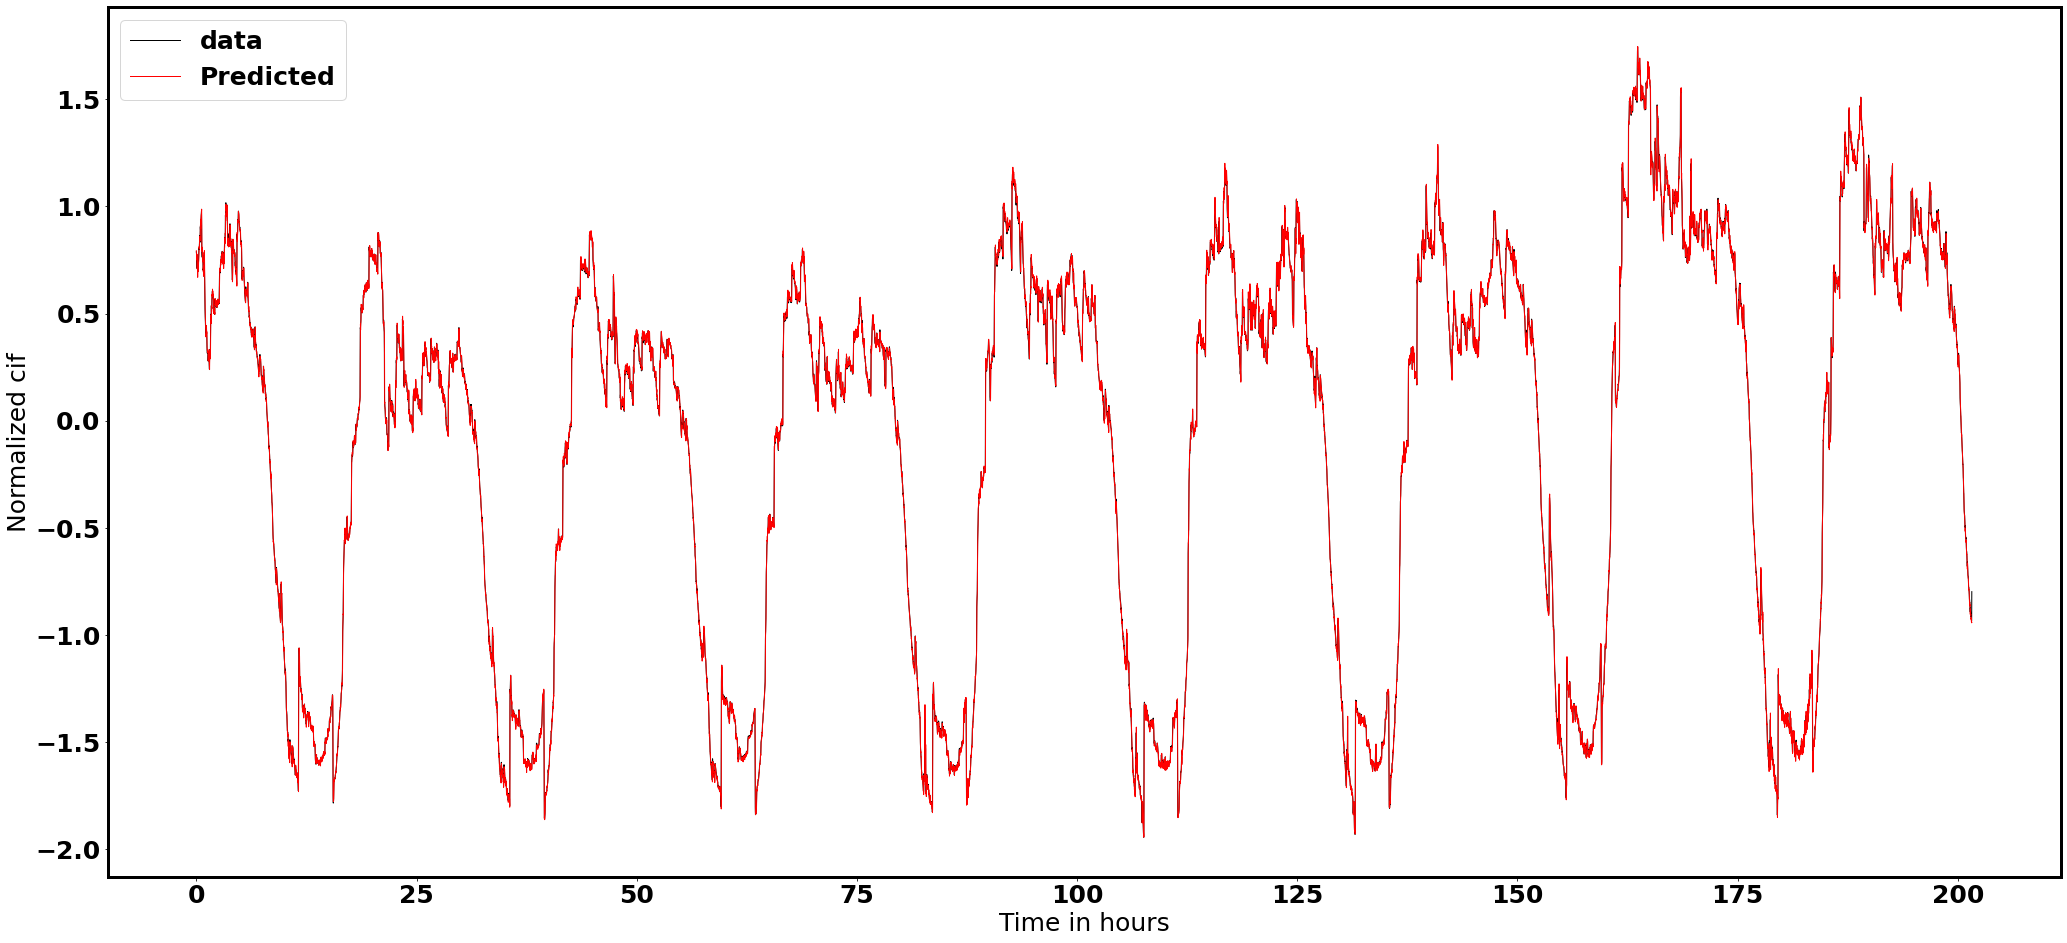

In [54]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_results" + ".png"

fig.savefig(save_path, dpi=150)




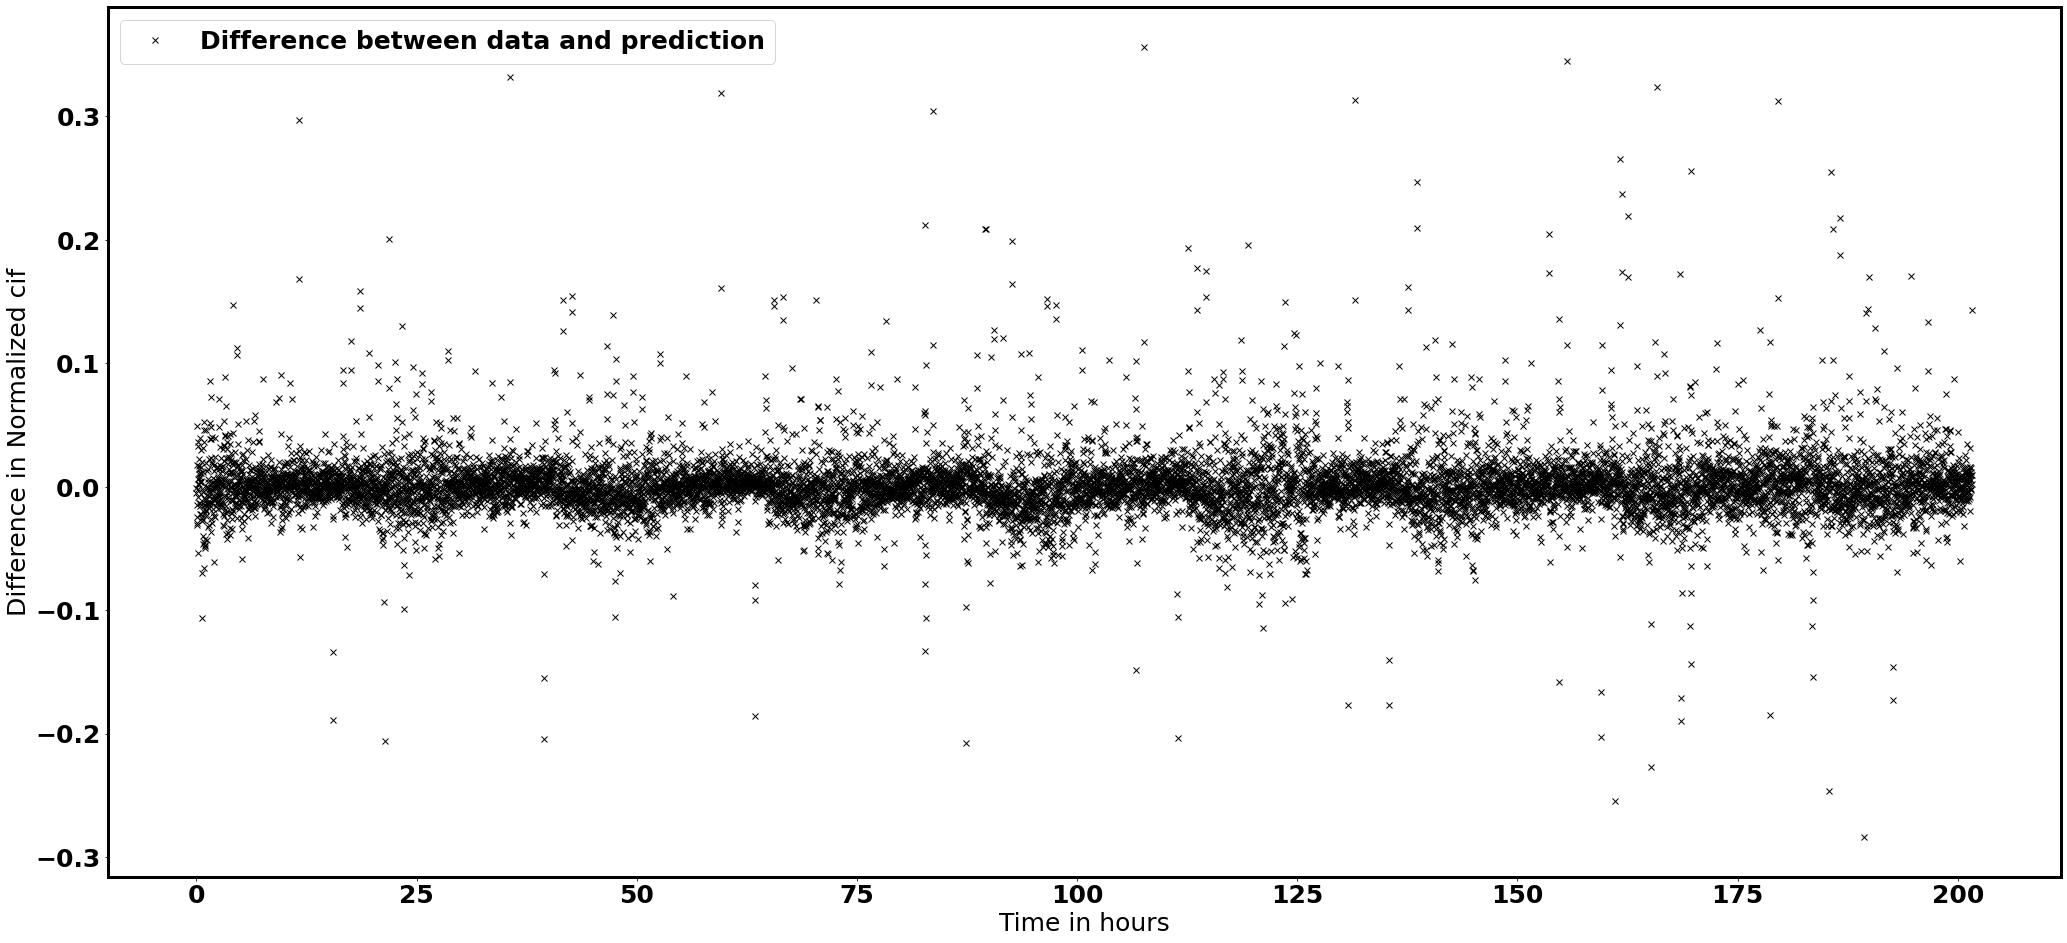

In [55]:
# plot difference in these values

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test-y_pre[:,0],"kx",label="Difference between data and prediction",alpha=1,linewidth=1)


plt.xlabel("Time in hours")
plt.ylabel("Difference in Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_results_diff" + ".png"

fig.savefig(save_path, dpi=150)





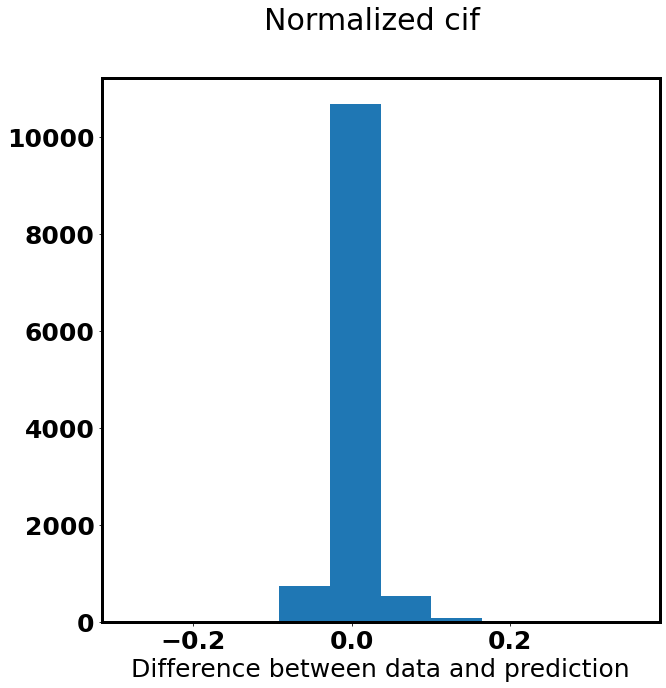

In [50]:
# The Difference in prediction and values:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


diff = y_test-y_pre[:,0]
plt.hist(diff)

plt.xlabel("Difference between data and prediction")
plt.suptitle("Normalized %s"%names_array[index_name])


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(10,10)
save_path = plot_path + "LSTM_results_hist_diff" + ".png"

fig.savefig(save_path, dpi=150)




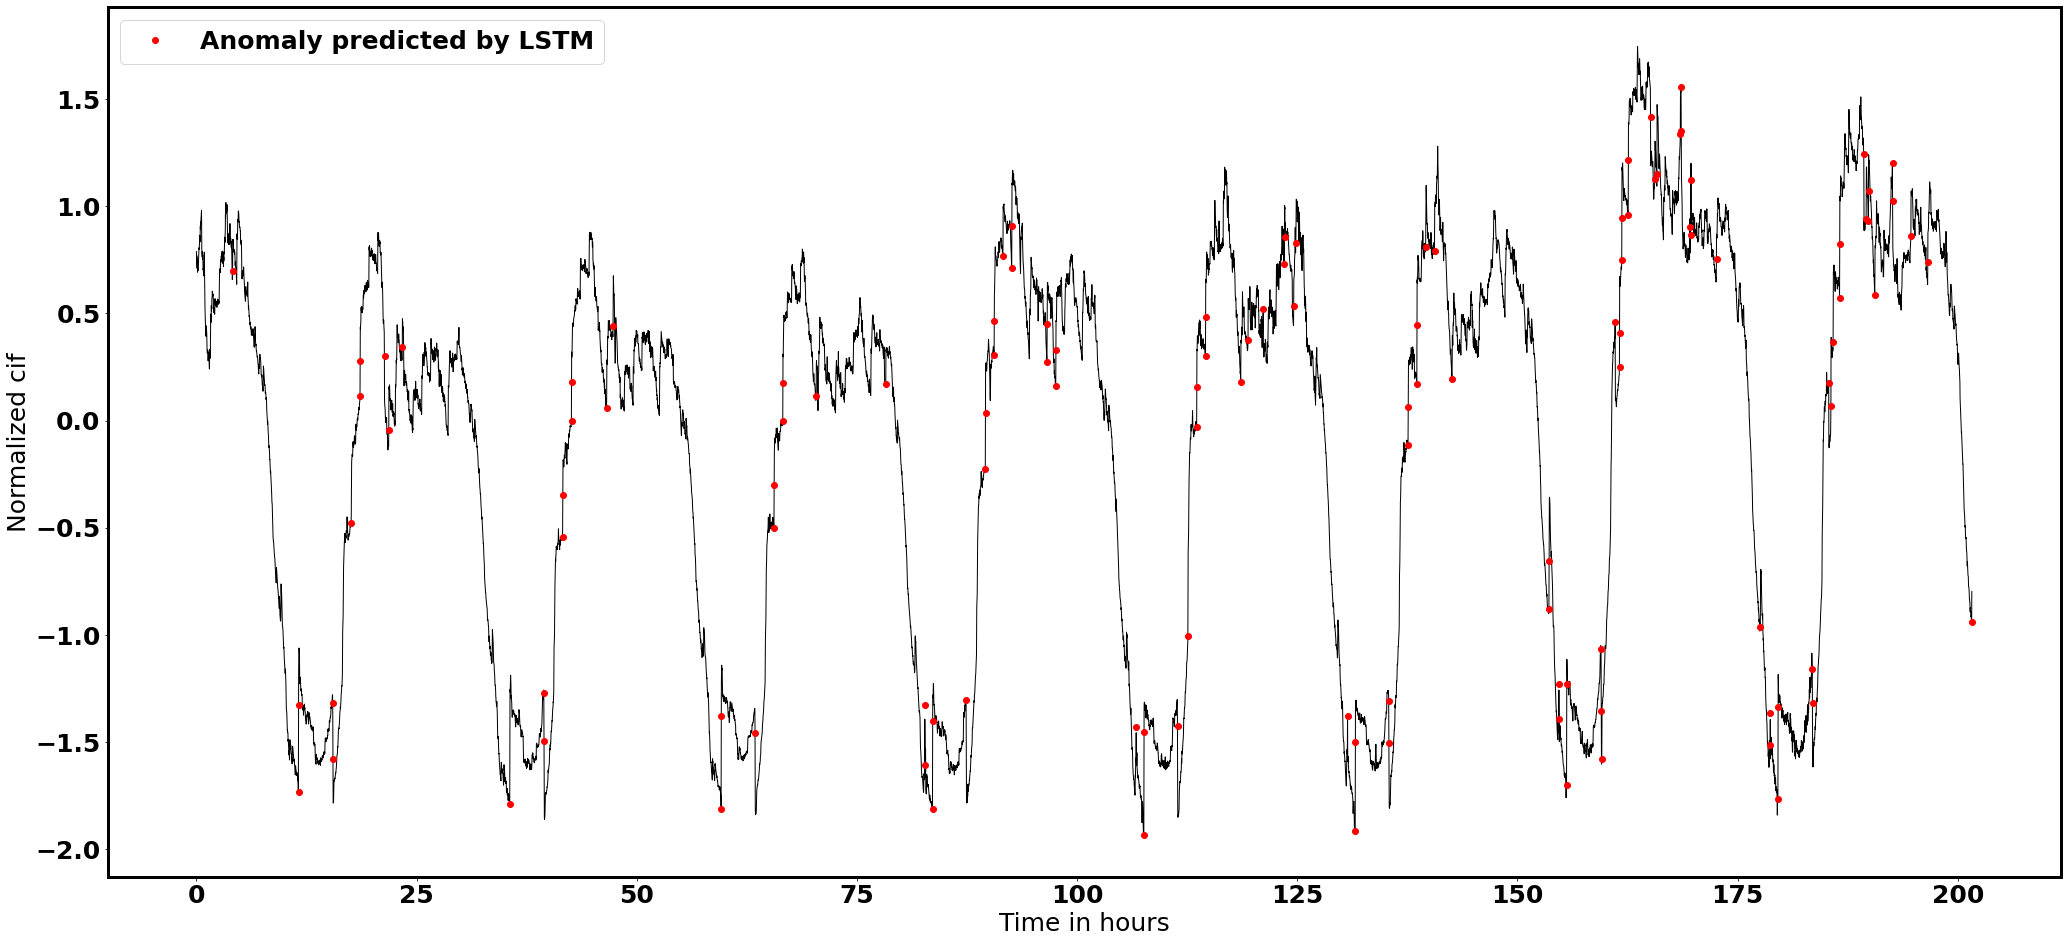

In [62]:
# Predict Anomaly using this rule

anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_pre[mask,0],"ro",label="Anomaly predicted by LSTM",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_anomaly_prediction" + ".png"

fig.savefig(save_path, dpi=150)



